In [35]:
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.exceptions import OptimizationError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
import requests
warnings.filterwarnings('ignore')

In [23]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

response = requests.get(url, headers=headers)

response.raise_for_status()

sp500 = pd.read_html(response.text)[0]


sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')


symbol_list = sp500['Symbol'].unique().tolist()


end_date = '2025-10-09'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=15)

df = yf.download(tickers=symbol_list[:10],
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()


vix_data = web.DataReader("VIXCLS", "fred", start_date, end_date)
vix_data.index.names = ['date']
vix_data.rename(columns={'VIXCLS':'vix'}, inplace=True)
df = df.join(vix_data, how='left')

# Garman-Klass Volatility
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2
)

# RSI
df['rsi'] = df.groupby('ticker')['adj close'].transform(lambda x: ta.rsi(x, length=20))

#df['rsi_state'] = np.select(
#    [df['rsi'] < 30, df['rsi'] > 70],
#    [-1, 1],
#    default=0
#)


# Bollinger Bands
def compute_bb(group, key):
 # log_close = np.log1p(group['adj close'])
 # bb = ta.bbands(close=log_close, length=20)
  bb = ta.bbands(close=group['adj close'], length=20)
  return bb.iloc[:,key]

df['bb_low'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 0)
df['bb_mid'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 1)
df['bb_high'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 2)

df['bb_position'] = ((df['adj close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']))



# ATR
def compute_atr(group):
    atr = ta.atr(group['high'], group['low'], group['close'], length=14)
    #return (atr - atr.mean()) / atr.std()
    return atr

df['atr'] = df.groupby('ticker', group_keys=False).apply(compute_atr)


# MACD
def compute_macd(group):
    macd_line = ta.macd(group, length=20).iloc[:, 0]
    #return (macd_line - macd_line.mean()) / macd_line.std()
    return macd_line

df['macd'] = df.groupby('ticker')['adj close'].transform(compute_macd)


# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

df

[*********************100%***********************]  10 of 10 completed


adj close       close        high         low        open  \
date       ticker                                                               
2010-10-11 A        21.448698   24.141630   24.299000   23.998569   24.155937   
           ABT      18.388657   25.338238   25.391016   25.227884   25.381420   
           ACN      34.404022   45.560001   45.740002   45.349998   45.480000   
           ADBE     27.250000   27.250000   27.490000   26.990000   27.049999   
           AES       7.991892   12.220000   12.410000   12.000000   12.040000   
...                       ...         ...         ...         ...         ...   
2025-10-08 AES      14.730000   14.730000   14.850000   14.320000   14.510000   
           AFL     111.900002  111.900002  113.290001  111.739998  113.000000   
           AMD     235.559998  235.559998  235.869995  210.699997  212.949997   
           AOS      71.070000   71.070000   71.540001   70.690002   71.449997   
           MMM     156.000000  156.000000  156.089996  152.779999  155.710007   

                        volume    vix  garman_klass_vol        rsi  \
date       ticker                                                    
2010-10-11 A         2680246.0  18.96         -0.005381        NaN   
           ABT      10334306.0  18.96         -0.040102        NaN   
           ACN       2699000.0  18.96         -0.030054        NaN   
           ADBE     10459000.0  18.96          0.000148        NaN   
           AES       6411600.0  18.96         -0.064311        NaN   
...                        ...    ...               ...        ...   
2025-10-08 AES      13480200.0  16.30          0.000573  61.539266   
           AFL       1756700.0  16.30          0.000058  60.758874   
           AMD     159983500.0  16.30          0.002434  81.109904   
           AOS        806300.0  16.30          0.000060  45.905525   
           MMM       2084200.0  16.30          0.000228  51.890629   

                       bb_low    bb_mid     bb_high  bb_position        atr  \
date       ticker                                                             
2010-10-11 A              NaN       NaN         NaN          NaN        NaN   
           ABT            NaN       NaN         NaN          NaN        NaN   
           ACN            NaN       NaN         NaN          NaN        NaN   
           ADBE           NaN       NaN         NaN          NaN        NaN   
           AES            NaN       NaN         NaN          NaN        NaN   
...                       ...       ...         ...          ...        ...   
2025-10-08 AES      11.891470   13.4915   15.091530     0.887024   0.531944   
           AFL     106.301045  109.9765  113.651956     0.761668   1.634655   
           AMD     126.358663  169.2485  212.138337     1.273044  11.222769   
           AOS      71.049801   72.7145   74.379199     0.006067   1.189641   
           MMM     152.274228  155.9115  159.548772     0.512166   3.155498   

                        macd  dollar_volume  
date       ticker                            
2010-10-11 A             NaN      57.487787  
           ABT           NaN     190.034004  
           ACN           NaN      92.856456  
           ADBE          NaN     285.007750  
           AES           NaN      51.240817  
...                      ...            ...  
2025-10-08 AES      0.413002     198.563340  
           AFL      1.574439     196.574733  
           AMD     11.254555   37685.712869  
           AOS     -0.013880      57.303741  
           MMM      0.454036     325.135200  

[37160 rows x 16 columns]

Change Between Monthly and Weekly:

In [24]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

                                                            # Change Here
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('W').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('W').last().stack('ticker')],
                  axis=1)).dropna()           # Change Here

data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank'] < 150].drop(columns=['dollar_vol_rank'],axis=1)


def calculate_returns(df):
    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
      df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))

    return df

data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()

def add_forward_returns(data, months_forward=1):
    data = data.copy()

    # Group by ticker and calculate forward return
    data[f'fwd_return_{months_forward}m'] = (
        data.groupby('ticker')['adj close']
            .transform(lambda x: x.shift(-months_forward) / x - 1)
    )
    
    return data

data = data.groupby('ticker', group_keys=False).apply(add_forward_returns).dropna()

data

dollar_volume   adj close    vix  garman_klass_vol  \
date       ticker                                                       
2011-05-01 A          136.657537   31.718634  14.75         -0.005995   
           ABT        327.283424   18.615479  14.75         -0.034493   
           ACN        134.059251   43.923645  14.75         -0.026303   
           ADBE       203.204482   33.549999  14.75          0.000100   
           AES         45.051019    8.658974  14.75         -0.067505   
...                          ...         ...    ...               ...   
2025-10-05 AES        167.282642   14.580000  16.65          0.000353   
           AFL        231.251486  112.320000  16.65          0.000130   
           AMD       5829.078848  164.669998  16.65          0.000524   
           AOS         90.208356   73.349998  16.65          0.000038   
           MMM        499.100560  158.660004  16.65          0.000141   

                         rsi      bb_low      bb_mid     bb_high  bb_position  \
date       ticker                                                               
2011-05-01 A       65.311684   27.333532   29.874059   32.414587     0.863030   
           ABT     66.140979   17.508617   18.195836   18.883056     0.805319   
           ACN     65.723278   41.133324   42.729392   44.325461     0.874123   
           ADBE    49.450604   33.142040   33.967500   34.792960     0.247110   
           AES     56.818362    8.156761    8.460485    8.764209     0.826758   
...                      ...         ...         ...         ...          ...   
2025-10-05 AES     61.497383   11.808526   13.230000   14.651474     0.974859   
           AFL     63.712263  105.510552  109.074000  112.637448     0.955458   
           AMD     53.525201  152.553870  160.048000  167.542131     0.808375   
           AOS     54.852402   71.432667   72.892500   74.352333     0.656695   
           MMM     56.592997  151.542653  155.581001  159.619348     0.881221   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2011-05-01 A       0.864908  0.943294   0.011552   0.025054   0.035967   
           ABT     0.392148  0.355258   0.004633   0.001348   0.013317   
           ACN     0.969557  0.869516   0.005633   0.022251   0.014866   
           ADBE    0.668514 -0.001281   0.002091  -0.014007  -0.005891   
           AES     0.295466  0.048993   0.017679   0.015852  -0.000503   
...                     ...       ...        ...        ...        ...   
2025-10-05 AES     0.549766  0.335430   0.101208   0.056996   0.042191   
           AFL     1.636146  1.442840   0.008621   0.019615   0.009650   
           AMD     5.740838  0.647402   0.032673   0.022866   0.012662   
           AOS     1.219647  0.312908   0.012422   0.001777   0.003570   
           MMM     3.064900  0.629330   0.038283   0.006556   0.001665   

                   return_6m  return_9m  return_12m  fwd_return_1m  
date       ticker                                                   
2011-05-01 A        0.025386   0.018391    0.012515      -0.003606  
           ABT      0.015475   0.010925    0.010910       0.009224  
           ACN      0.022995   0.011029    0.007667      -0.034658  
           ADBE     0.007967  -0.003514    0.000473      -0.004471  
           AES      0.012212   0.008581    0.005342      -0.023414  
...                      ...        ...         ...            ...  
2025-10-05 AES      0.013035   0.010854    0.013441       0.010288  
           AFL      0.005845   0.015780    0.008876      -0.003739  
           AMD     -0.003094  -0.004634    0.009837       0.430497  
           AOS     -0.000590   0.004556    0.005414      -0.031084  
           MMM      0.000706   0.011029    0.001880      -0.016765  

[7424 rows x 18 columns]

Change Between Monthly and Weekly

In [25]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
                                # Change Here
factor_data = factor_data.resample('W').last().div(100)

factor_data.index.name = 'date'
factor_data = factor_data.ffill() # only use when doing weekly

factor_data = factor_data.join(data['return_1m']).sort_index()


observations = factor_data.groupby('ticker').size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]


betas = (factor_data.groupby('ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                      window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2011-05-01 A            NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
           AES          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-08-03 AES     1.688522 -1.419589  2.137784  1.150436 -1.954712
           AFL    -0.227230 -0.281582 -0.177245 -0.086406  0.162735
           AMD     0.746542  0.272031  0.433834 -0.039531 -0.323730
           AOS     0.476865 -0.314181  0.281912  0.475625 -0.782434
           MMM    -0.133423 -0.018309 -0.624695  0.337933  0.390381

[7334 rows x 5 columns]

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift(1)))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop(['dollar_volume','bb_low', 'bb_mid', 'bb_high'], axis=1)

data = data.dropna()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7424 entries, (Timestamp('2011-05-01 00:00:00'), 'A') to (Timestamp('2025-10-05 00:00:00'), 'MMM')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         7424 non-null   float64
 1   vix               7424 non-null   float64
 2   garman_klass_vol  7424 non-null   float64
 3   rsi               7424 non-null   float64
 4   bb_position       7424 non-null   float64
 5   atr               7424 non-null   float64
 6   macd              7424 non-null   float64
 7   return_1m         7424 non-null   float64
 8   return_2m         7424 non-null   float64
 9   return_3m         7424 non-null   float64
 10  return_6m         7424 non-null   float64
 11  return_9m         7424 non-null   float64
 12  return_12m        7424 non-null   float64
 13  fwd_return_1m     7424 non-null   float64
 14  Mkt-RF            7424 non-null   float64
 15  SMB           

Kalman Filter

In [52]:
lstm_data = data.xs('AFL', level='ticker')
lstm_data.drop(columns=['fwd_return_1m'],inplace=True)
lstm_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2011-05-01 to 2025-10-05
Freq: W-SUN
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         754 non-null    float64
 1   vix               754 non-null    float64
 2   garman_klass_vol  754 non-null    float64
 3   rsi               754 non-null    float64
 4   bb_position       754 non-null    float64
 5   atr               754 non-null    float64
 6   macd              754 non-null    float64
 7   return_1m         754 non-null    float64
 8   return_2m         754 non-null    float64
 9   return_3m         754 non-null    float64
 10  return_6m         754 non-null    float64
 11  return_9m         754 non-null    float64
 12  return_12m        754 non-null    float64
 13  Mkt-RF            754 non-null    float64
 14  SMB               754 non-null    float64
 15  HML               754 non-null    float64
 16  RMW          

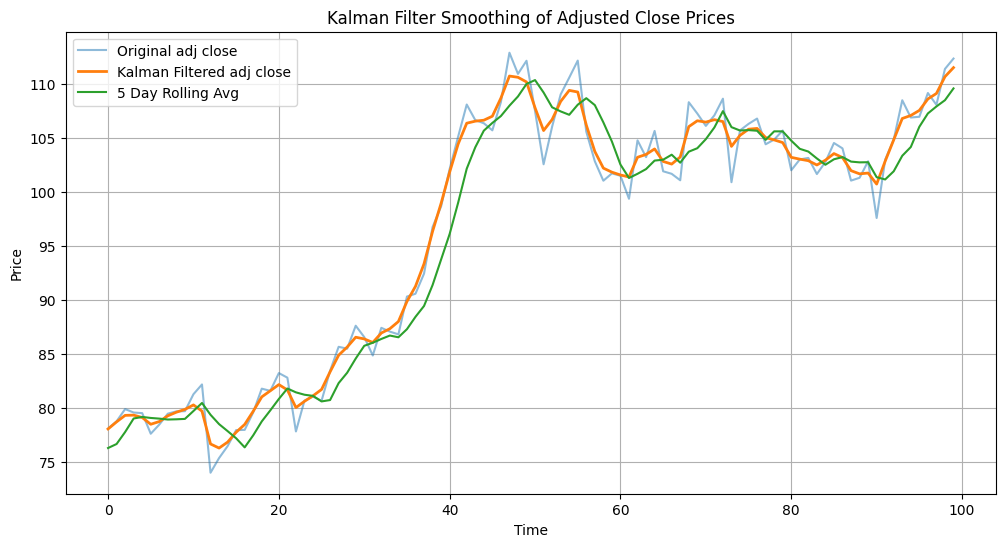

In [72]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Assume lstm_data is your DataFrame and 'adj close' is the column of interest
adj_close = lstm_data['adj close'].values

# Initialize Kalman Filter
kf = KalmanFilter(initial_state_mean=adj_close[0], n_dim_obs=1)

# Estimate the state with Kalman Filter (smoothing)
state_means, _ = kf.smooth(adj_close)
state_means = state_means[4:]
adj_close = adj_close[4:]


# Plot original vs Kalman filtered
plt.figure(figsize=(12, 6))
plt.plot(adj_close[-100:], label='Original adj close', alpha=0.5)
plt.plot(state_means[-100:], label='Kalman Filtered adj close', linewidth=2)
plt.plot(lstm_data['adj close'].rolling(window=5).mean().reset_index('date').drop(columns='date').dropna()['adj close'].to_list()[-100:], label='5 Day Rolling Avg')
plt.title('Kalman Filter Smoothing of Adjusted Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2999 - val_loss: 10231.4688
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281 - val_loss: 10199.5195
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - val_loss: 10187.0654
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - val_loss: 10179.4551
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - val_loss: 10166.6729
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 10166.0371
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 10158.0850
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 10152.4287
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 10140.5938
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 10135.1904
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 10136.4736
Epoch 12/50
42/42 ━━━━━━━━━━━

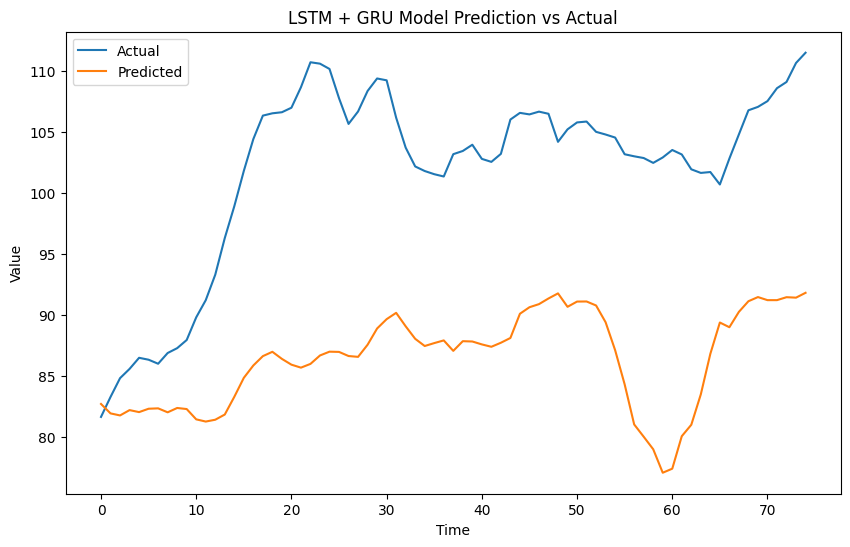

Model Performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10070.7314
Test Loss: 10070.7314453125


In [ ]:
lstm_data['adj close'] = state_means
vals = lstm_data.values

n_steps = 12 # Best at 25 so far
X, y = [], []
for i in range(n_steps, len(vals)):
    X.append(vals[i - n_steps:i, :])
    y.append(vals[i, 0])

X, y = np.array(X), np.array(y)

split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Initialize scalers
scalers = {}
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

for i in range(X.shape[2]):
    scalers[i] = StandardScaler()
    
    # Flatten to 2D: (samples * timesteps, 1)
    train_feat = X_train[:, :, i].reshape(-1, 1)
    test_feat = X_test[:, :, i].reshape(-1, 1)
    
    # Fit only on train
    scalers[i].fit(train_feat)
    
    # Transform and reshape back
    X_train_scaled[:, :, i] = scalers[i].transform(train_feat).reshape(X_train.shape[0], X_train.shape[1])
    X_test_scaled[:, :, i] = scalers[i].transform(test_feat).reshape(X_test.shape[0], X_test.shape[1])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()



model = Sequential()
model.add(LSTM(units=41,                # best units = 41
                return_sequences=True,
                input_shape=(n_steps, X.shape[2]),
                activation='tanh',
                recurrent_activation="sigmoid",
                use_bias=True,
                kernel_initializer="glorot_uniform",
                recurrent_initializer="orthogonal",
                bias_initializer="zeros",
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
           #     dropout=0.01,
                recurrent_dropout=0.0,
                seed=None,
                return_state=False,
                go_backwards=False,
                stateful=False,
                unroll=False,
                use_cudnn="auto"))

model.add(LSTM(units=41,               # best units = 41
                return_sequences=True,
                activation='tanh',
                recurrent_activation="sigmoid",
                use_bias=True,
                kernel_initializer="glorot_uniform",
                recurrent_initializer="orthogonal",
                bias_initializer="zeros",
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
              #  dropout=0.01,
                recurrent_dropout=0.0,
                seed=None,
                return_state=False,
                go_backwards=False,
                stateful=False,
                unroll=False,
                use_cudnn="auto"))

model.add(GRU(units=58,
              return_sequences=False,
              activation="tanh",
              recurrent_activation="sigmoid",
              use_bias=True,
              kernel_initializer="glorot_uniform",
              recurrent_initializer="orthogonal",
              bias_initializer="zeros",
              kernel_regularizer=None,
              recurrent_regularizer=None,
              bias_regularizer=None,
              activity_regularizer=None,
              kernel_constraint=None,
              recurrent_constraint=None,
              bias_constraint=None,
              dropout=0.0,
              recurrent_dropout=0.0,
              seed=None,
              return_state=False,
              go_backwards=False,
              stateful=False,
              unroll=False,
              reset_after=True,
              use_cudnn="auto")) # best units = 58

model.add(Dense(units=1,
                activation='linear'))


model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='mean_squared_error') # lr = 0.0005181785280568014


history = model.fit(X_train_scaled,
                    y_train_scaled,
                    epochs=50,
                    batch_size=16,  # Optimal Batch Size = 16
                    validation_data=(X_test, y_test))


predictions = model.predict(X_test_scaled)

predictions = y_scaler.inverse_transform(predictions)
y_test_original =y_scaler.inverse_transform(y_test_scaled.reshape(-1,1))


plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM + GRU Model Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


print("Model Performance:")
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


In [ ]:
vals = lstm_data.drop('fwd_return_1m').values

n_steps = 12 # Best at 25 so far
X, y = [], []
for i in range(n_steps, len(vals)):
    X.append(vals[i - n_steps:i, :])
    y.append(vals[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test = scaler_y.transform(y_test.reshape(-1, 1))

model = Sequential()
model.add(LSTM(units=41,                # best units = 41
                return_sequences=True,
                input_shape=(n_steps, X.shape[2]),
                activation='tanh',
                recurrent_activation="sigmoid",
                use_bias=True,
                kernel_initializer="glorot_uniform",
                recurrent_initializer="orthogonal",
                bias_initializer="zeros",
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
           #     dropout=0.01,
                recurrent_dropout=0.0,
                seed=None,
                return_state=False,
                go_backwards=False,
                stateful=False,
                unroll=False,
                use_cudnn="auto"))

model.add(LSTM(units=41,               # best units = 41
                return_sequences=True,
                activation='tanh',
                recurrent_activation="sigmoid",
                use_bias=True,
                kernel_initializer="glorot_uniform",
                recurrent_initializer="orthogonal",
                bias_initializer="zeros",
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
              #  dropout=0.01,
                recurrent_dropout=0.0,
                seed=None,
                return_state=False,
                go_backwards=False,
                stateful=False,
                unroll=False,
                use_cudnn="auto"))

model.add(GRU(units=58,
              return_sequences=False,
              activation="tanh",
              recurrent_activation="sigmoid",
              use_bias=True,
              kernel_initializer="glorot_uniform",
              recurrent_initializer="orthogonal",
              bias_initializer="zeros",
              kernel_regularizer=None,
              recurrent_regularizer=None,
              bias_regularizer=None,
              activity_regularizer=None,
              kernel_constraint=None,
              recurrent_constraint=None,
              bias_constraint=None,
              dropout=0.0,
              recurrent_dropout=0.0,
              seed=None,
              return_state=False,
              go_backwards=False,
              stateful=False,
              unroll=False,
              reset_after=True,
              use_cudnn="auto")) # best units = 58

model.add(Dense(units=1,
                activation='linear'))


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error') # lr = 0.0005181785280568014


history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=16,  # Optimal Batch Size = 16
                    validation_data=(X_test, y_test))


predictions = model.predict(X_test)

predictions = scaler_y.inverse_transform(predictions)
y_test_original =scaler_y.inverse_transform(y_test)


plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM + GRU Model Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


print("Model Performance:")
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")